## NITE regulation
**Identifying divergence between local chromatin accessibility and gene expression**

A general assumption made in single-cell analysis (gene scoring, data integration, etc.) is that changes in local chromatin accessibility correspond to changes in gene expression. We found that assumption is frequently violated, and that when chromatin accessibiltity diverges from gene expression this has interesting implications for regulation and signaling. The next tutorial demonstrates how to use RP modeling to quantify the divergence between modes.

First, an introduction of terms:

 - **L**ocal chromatin accessibility-**I**nfluenced **T**ranscriptional **E**xpression (**LITE**) model: learns a relationship between a gene and its local chromatin only.

 - **N**on-local chromatin accessibility-**I**nfluenced **T**ranscriptional **E**xpression (**NITE**) model: extends the LITE model to relate genome-wide changes in chromatin to gene expression via the learned accessibility topics.

Since the NITE model has an expanded scope and can learn a relationship with genome-wide changes in chromatin rather than just local changes, this model is strictly better at predicting expression than the LITE model. By comparing the predictive capacity of local (LITE) vs. genome wide (NITE) chromatin changes, one can address if transcriptional regulation of a gene is modulated through local chromatin or through some other nonlocal regulatory mechanism.

By extension, one can also see if in certain cell states gene expression is more or less determined by the local chromatin landscape.

Let’s import some packages:

In [12]:
!hostnamectl

   Static hostname: psh01com1hcom40
         Icon name: computer-server
           Chassis: server
        Machine ID: 96f6166d8c254e2e93a2d98b24996b27
           Boot ID: 635310819e254cabb54b3b6e944f8453
  Operating System: ]8;;https://www.redhat.com/Red Hat Enterprise Linux 8.10 (Ootpa)]8;;
       CPE OS Name: cpe:/o:redhat:enterprise_linux:8::baseos
            Kernel: Linux 4.18.0-553.22.1.el8_10.x86_64
      Architecture: x86-64


In [3]:
import mira
import scanpy as sc
import anndata
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", size = 12)
import seaborn as sns
mira.utils.pretty_sderr()

In [5]:
rna_adata = anndata.read_h5ad("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_rna_data_tf_tg_scores.h5ad")
atac_adata = anndata.read_h5ad("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_atac_data_tss_dist.h5ad")

ds011_atac_model = mira.topics.load_model("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_atac_model.pth")
ds011_rna_model = mira.topics.load_model("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_rna_model.pth")

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


### Training NITE Models

The NITE model is an extension of the LITE model, but with an awareness of the genome-wide chromatin landscape. First, we need to load in some LITE models. This cell loads the LITE models trained in the previous tutorial.

In [13]:
rp_args = dict(expr_adata = rna_adata, atac_adata = atac_adata)

litemodel = mira.rp.LITE_Model.load_dir(
    expr_model = ds011_rna_model,
    accessibility_model = ds011_atac_model,
    prefix='/gpfs/Home/esm5360/MIRA/data/ds011_rpmodels/'
)
litemodel.predict(**rp_args)

Predicting expression:   0%|          | 0/2674 [00:00<?, ?it/s]

KeyboardInterrupt: 

Then, we can use the `spawn_NITE_model` function to initialize a NITE model object. The spawn function seeds the parameters of the NITE model with the pretrained values from the LITE model, and sets up the NITE model to reference the same topic models and genes.

In [6]:
nitemodel = litemodel.spawn_NITE_model()

Now we can fit the NITE model parameters. The API for the NITE model is identical to the LITE model. The code below fits the parameters, then predicts gene expression given the genome-wide chromatin state.

In [ ]:
nitemodel.fit(**rp_args, n_workers=12)

In [8]:
nitemodel.save("/gpfs/Home/esm5360/MIRA/data/ds011_rpmodels/")

Loading the model

In [7]:
from mira.rp_model import NITE_Model

rp_args = dict(expr_adata = rna_adata, atac_adata = atac_adata)
nitemodel = NITE_Model.load_dir(
    expr_model = ds011_rna_model,
    accessibility_model = ds011_atac_model,
    prefix='/gpfs/Home/esm5360/MIRA/data/ds011_rpmodels/'
    )

In [9]:
nitemodel.predict(**rp_args)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2674 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
nitemodel.save("/gpfs/Home/esm5360/MIRA/data/ds011_rpmodels/")

### Chromatin differential

We define chromatin differential as the log-ratio of the LITE model prediction vs. the NITE model prediction of gene expression. When these two models predict similar values, chromatin differential is close to zero. If the LITE model over-estimates expression (say in the case of lineage priming) then chromatin differential increases. In the plots below, over-estimation is indicated in Red. First, calculate chromatin differential:

In [8]:
mira.tl.get_chromatin_differential(rna_adata)

KeyError: 'User must run "predict" using a trained nite_model before running this function'

Now plot using `mira.pl.plot_chromatin_differential`. For each gene, the expression and local chromatin/LITE prediction are shown. Then, chromatin differential is shown with Red indicating the LITE model **over-estimates** expession compared to the all-seeing NITE model. The chromatin differential color range is the same for each gene, so we can compare the magnitude across genes.

Finally, we plot the NITE vs. LITE predictions in a scatterplot, colored by observed expression counts. This final plot is most insteresting, and visually represents the predictive capacity of the LITE and NITE models. A simple way to read this plot is to imagine it is expression (NITE prediction) as a function of local chromatin accessibility (LITE prediction).

We can compare the LITE or NITE prediction against the gradient of observed expression to assess the goodness of fit. If most of the points are on the diagonal, then both models agree on expression rate.

Conversely, when cells jut off the diagonal, there is disagreement between LITE and NITE models. For **KRT23** (bottom), there is a group of cells where the LITE model suggests a medium-high expression rate, but the NITE model correctly assess these cells as having low KRT expression. These cells are colored dark red on the adjacent plot.

In [ ]:
rna_adata.write_h5ad("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_rna_data_chrom_diff.h5ad")

In [10]:
rna_adata.var_names

Index(['Xkr4', 'Mrpl15', 'Lypla1', 'Tcea1', 'Atp6v1h', 'Rb1cc1',
       '4732440D04Rik', 'Pcmtd1', 'Gm26901', 'Rrs1',
       ...
       'Tmsb4x', 'Prps2', 'Msl3', 'Arhgap6', 'Hccs', 'Gm15246', 'Mid1',
       'Eif2s3y', 'Uty', 'Ddx3y'],
      dtype='object', length=10719)

In [11]:
rna_adata.obs_names

Index(['AAACCAACATAATCCG-1', 'AAACCGAAGTCATCCC-1', 'AAACCGCGTTAACACG-1',
       'AAACCGCGTTGAGCCG-1', 'AAACGGATCAGGGCCT-1', 'AAACGGATCATGCGTG-1',
       'AAAGCTTGTAACAGGG-1', 'AAAGGACGTGGACCTG-1', 'AAAGGACGTTGTAAAC-1',
       'AAAGGACGTTGTCATC-1',
       ...
       'TTTACGCGTTGCAATG-1', 'TTTAGGATCAGTGAAG-1', 'TTTAGGATCGGCCATA-1',
       'TTTCCACCATAGCTGC-1', 'TTTCCTGAGCGCATTG-1', 'TTTCCTGAGGAGCATA-1',
       'TTTGCGGAGGACCTTG-1', 'TTTGTCCCAAAGCGGC-1', 'TTTGTGAAGGCCTAAT-1',
       'TTTGTTGGTAAAGCGG-1'],
      dtype='object', length=894)

In [ ]:
import pandas as pd
chrom_diff = pd.DataFrame(rna_adata.layers["chromatin_differential"].toarray(), columns=rna_adata.var_names, index=rna_adata.obs_names)
chrom_diff

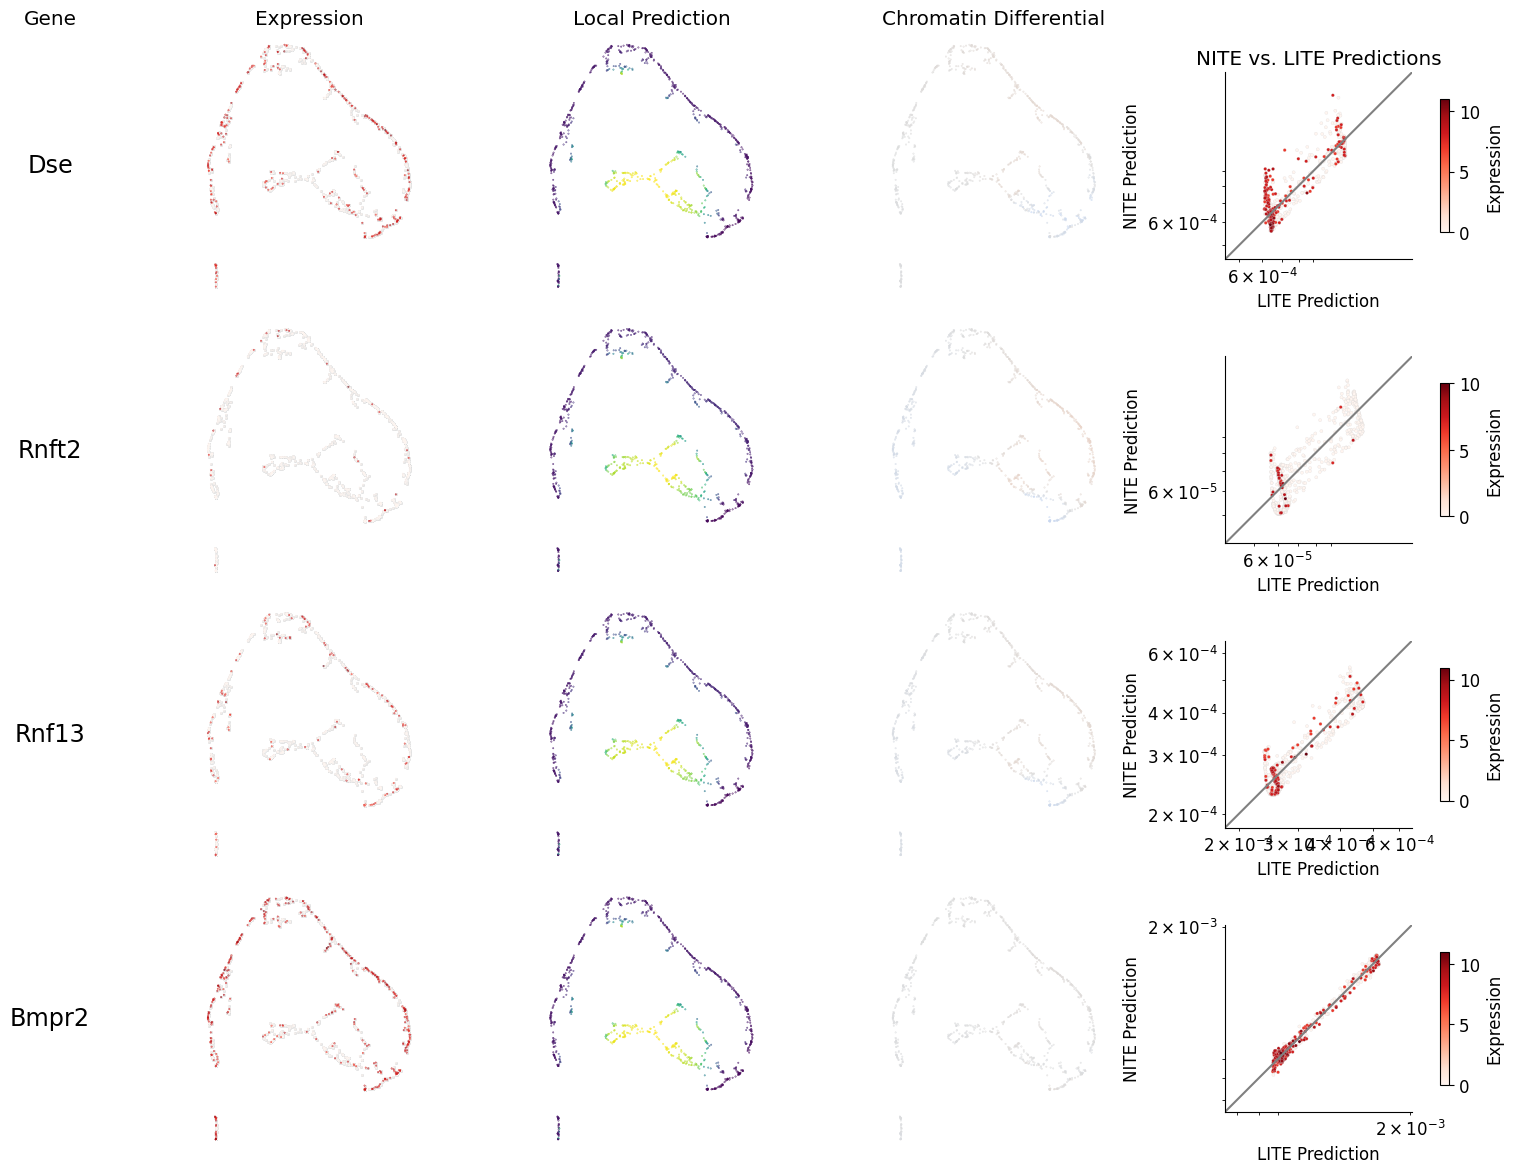

In [16]:
mira.pl.plot_chromatin_differential(rna_adata, genes = litemodel.genes[0:4],
                                    show_legend=False, size = 0.1, aspect=1.2)
plt.show()